In [1]:
import sys
sys.path.insert(0, '../python_scripts')
import json
import glob
import h_gen
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tq
import matplotlib.patches as patches
import numpy as np
from PIL import Image
import utils
import importlib
import meta
metadata = utils.load("./variables/metadata.p")
from keras.optimizers import *
from keras.models import Sequential
from keras.layers import *
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
import os
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
remote = callbacks.RemoteMonitor(root='http://localhost:9000')
from shutil import copyfile
import threading
import PIL
from keras.models import load_model
importlib.reload(utils)
importlib.reload(meta)
from keras.preprocessing.image import img_to_array,array_to_img

Using Theano backend.
DEBUG: nvcc STDOUT nvcc warning : The 'compute_20', 'sm_20', and 'sm_21' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).
mod.cu
   Creating library C:/Users/yolo/AppData/Local/Theano/compiledir_Windows-10-10.0.14393-SP0-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-3.5.2-64/tmpsyiqviwo/m91973e5c136ea49268a916ff971b7377.lib and object C:/Users/yolo/AppData/Local/Theano/compiledir_Windows-10-10.0.14393-SP0-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-3.5.2-64/tmpsyiqviwo/m91973e5c136ea49268a916ff971b7377.exp

Using gpu device 0: GeForce GTX 970 (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 5105)
C:\Program Files\Anaconda3\lib\site-packages\theano\sandbox\cuda\__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [2]:
#meta.generate_cluster_from_imgs("./train/",size=(200,200))

In [3]:
import theano.sandbox.cuda.basic_ops as sbcuda
sbcuda.cuda_ndarray.cuda_ndarray.mem_info()[0] /(1024**3)

0.08145446702837944

In [4]:
def create_cust1(nb_channels = 512):
    img_input = Input(shape=(nb_channels,) + (None,None)) 
    x = BatchNormalization(axis=1)(img_input)
    nb_output_channels = 512
    x = Convolution2D(512, 1, 1, activation='relu')(x)
    x = BatchNormalization(axis=1)(x)
    x = Convolution2D(nb_output_channels, 1, 1, activation='relu')(x)
    x = GlobalMaxPooling2D()(x)
    return Model(img_input, x), nb_output_channels

In [5]:
def create_cust2(nb_channels):
    img_input = Input(shape=(nb_channels,)) 
    x = BatchNormalization(axis=1)(img_input)
    x = Dense(256, activation='relu')(x)
    x = Dense(8, activation="softmax")(x)
    return Model(img_input, x)

In [6]:
def create_complete_network(nb_branches = 2):
    
    # Our three networks, all the weights will be shared.
    vgg = VGG16(include_top=False)
    
    for layer in vgg.layers:
        layer.trainable = False
    cust1, nb_channels  = create_cust1(512)
    cust2 = create_cust2(nb_channels)
    
    
    inputs = [Input(shape=(3, None, None)) for _ in range(nb_branches)]
    vgg_outs = [vgg(x) for x in inputs]
    cust1_outs = [cust1(x) for x in vgg_outs]
    
    reshaped = [Reshape((1, nb_channels))(x) for x in cust1_outs]
    
    # We merge and complete the max pooling operation
    merge_out = Merge(mode='concat', concat_axis=1)(reshaped)

    complete_max_pool = GlobalMaxPooling1D()(merge_out)
    
    
    predictions = cust2(complete_max_pool)
    
    
    return Model(inputs, predictions)

In [7]:
model = create_complete_network(4)

In [8]:
# This will return the type of rectangle to use
class CustomIterator(object):

    def __init__(self, batch_size, nb_branches):
        self.batch_size = batch_size
        self.nb_branches = nb_branches
        self.lock = threading.Lock()
        self.index_generator = self._flow_index(batch_size, nb_branches)

    def _flow_index(self, batch_size, nb_branches):
        up_lim = 300
        low_lim = 50
        
        matrix_indicators = np.zeros((batch_size, nb_branches))
        range_of_sizes = np.arange(low_lim, up_lim)
        
        probas = np.arange(up_lim-low_lim)[::-1]/np.sum(np.arange(up_lim-low_lim))
        
        while 1:
            
            sizes = np.random.choice(range_of_sizes, 2*nb_branches, p=probas)
            rectangle_sizes = np.reshape(sizes, (nb_branches, 2))
            
            # We need to know the labels:
            labels = np.random.choice(8, batch_size)
            
            matrix_indicators[:,0] = labels
            
            for i, label in enumerate(labels):
                
                # If the label is Nof
                if label == 0:
                    matrix_indicators[i,1:] = np.random.choice([0, 8] ,nb_branches-1,p=[0.75,0.25])
                
                # If the label is a fish:
                else:
                    matrix_indicators[i,1:] = np.random.choice([label, 0, 8] ,nb_branches-1,p=[0.6,0.2,0.2])

            yield matrix_indicators, rectangle_sizes,

    def __iter__(self):
        # needed if we want to do something like:
        # for x, y in data_gen.flow(...):
        return self

    def __next__(self, *args, **kwargs):
        return self.next(*args, **kwargs)

In [9]:
import random
random.choice(list(metadata.items()))

('img_04243.jpg',
 {'angle': 142.40094913655213,
  'class': 'ALB',
  'code': 2,
  'filename': 'img_04243.jpg',
  'head_tail': [{'x': 439.92000000000127, 'y': 487.86000000000143},
   {'x': 568.3171045769975, 'y': 388.98430659436707}],
  'height': 720,
  'ht_first': True,
  'path': './train/ALB/img_04243.jpg',
  'rectangles': [{'height': 105.26899013331587,
    'width': 133.06000352851134,
    'x': 420.23380861219715,
    'y': 400.0221625066005}],
  'width': 1280})

In [10]:
importlib.reload(utils)
importlib.reload(meta)

<module 'meta' from 'C:\\Users\\yolo\\Desktop\\fish\\meta.py'>

In [11]:
cluster_0_train = meta.get_cluster_data("cluster_0_train.p")
cluster_1_train = meta.get_cluster_data("cluster_1_train.p")
cluster_0_test = meta.get_cluster_data("cluster_0_test.p")
cluster_1_test = meta.get_cluster_data("cluster_1_test.p")
a = np.array([len(cluster_0_train[i]) for i in cluster_0_train])
b = np.array([len(cluster_1_train[i]) for i in cluster_1_train])
c = np.array([len(cluster_0_test[i]) for i in cluster_0_test])
d = np.array([len(cluster_1_test[i]) for i in cluster_1_test])
print(a)
print(b)
print(c)
print(d)

[ 168   32  139  422 1162  320   50   59]
[ 79  61  20 164 210  44   3  81]
[ 42   8  35 106 291  80  13  15]
[20 16  5 42 53 11  1 21]


In [12]:
reverse_classes_dictionary = meta.get_reverse_classes_dictionary()

In [13]:
def load_crop_resize_no_fish(img_path,rect_size):
    from keras.preprocessing.image import img_to_array
    img = Image.open(img_path)
    W,H = img.size
    w,h = rect_size 
    img = img_to_array(img)
    x = int(np.random.uniform(0,W-w))
    y = int(np.random.uniform(0,H-h))
    #return preprocess_input(np.expand_dims(img[:,y:y+h,x:x+w],axis=0))[0]
    return img[:,y:y+h,x:x+w]

def load_crop_resize_fish(img_path,rdn_r,rect_size,option):
    from keras.preprocessing.image import img_to_array
    img = Image.open(img_path)
    W,H = img.size
    x,y,w,h = rdn_r
    
    img = Image.open(img_path)
    #print(img.size)
    img0 = img_to_array(img)
    #print(x+w,y+h,w,h)

    ####### THERE IS AN ERROR HERE ########################################
    #if w > 1280 and h < 720:
    #    img0 = img_to_array(img.crop((np.max([x,0]),np.max([y,0]),np.min([np.max([x,0])+w,1280]),720)))
    #if w < 1280 and h > 720:
    #    img0 = img_to_array(img.crop((np.max([x,0]),np.max([y,0]),1280,np.min([np.max([y,0])+h,720]))))
    #if w > 1280 and h > 720:
    #    img0 = img_to_array(img.crop((np.max([x,0]),np.max([y,0]),1280,720)))                                  
    #if w < 1280 and h < 720:
    #img0 = preprocess_input(np.expand_dims(img_to_array(img.crop((np.max([x,0]),np.max([y,0]),np.min([np.max([x,0])+w,W]),np.min([np.max([y,0])+h,H])))),axis=0))[0]
    img0 = img_to_array(img.crop((np.max([x,0]),np.max([y,0]),np.min([np.max([x,0])+w,W]),np.min([np.max([y,0])+h,H]))))
    ####### THERE IS AN ERROR HERE ########################################
    #plt.imshow(array_to_img(img0))
    #plt.show()
    
    
    shape = img0.shape
    #print(shape)
    return img0,shape[1],shape[2]


In [14]:
class DiskArrayIterator(CustomIterator):
    
    def __init__(self, batch_size, nb_branches, metadata,cluster0,cluster1,
                 reverse_classes_dictionary,pourcentage,N,option=0, image_data_generator=None):
        self.batch_size=batch_size
        self.nb_branches=nb_branches
        self.cluster0 = cluster0
        self.cluster1 = cluster1
        self.metadata = metadata
        self.prt = pourcentage
        self.reverse_classes_dictionary = reverse_classes_dictionary
        self.option = option
        self.N = N
        self.image_data_generator = image_data_generator
        
        # We need to classify filenames by class
        """by_class = [[] for _ in range(8)]
        for key, v in metadata.items():
            
            # We check for any potential bug
            if v["code"] != 0 and ("rectangles" not in v or len(v["rectangles"]) == 0):
                continue
                
            by_class[v["code"]].append(key)
            
        self.by_class = by_class"""
        
        super(DiskArrayIterator, self).__init__(batch_size, nb_branches)

    def next(self):
        with self.lock:
            indicators, rectangle_sizes = next(self.index_generator)
            
        labels = utils.to_categorical(indicators[:,0],8)
        X = [np.zeros((len(indicators),3,rect_size[1],rect_size[0])) for rect_size in rectangle_sizes]
        if self.option == 2:
            X = [np.zeros((len(indicators),3,1300,1200)) for _ in rectangle_sizes]
            W_max = [[300] for i in range(len(rectangle_sizes)) ]
            H_max = [[300] for i in range(len(rectangle_sizes)) ]
        for i,indicator in enumerate(indicators):
            for j,rect_size in enumerate(rectangle_sizes):
                wanted_class = str(int(indicator[j]))
                cluster_choice = np.random.choice([0,1] ,p=[0.5,0.5])
                rect_size = rectangle_sizes[j]
                if cluster_choice == 0 :
                    if wanted_class== '0':
                        random_img_name = np.random.choice(self.cluster0[self.reverse_classes_dictionary[wanted_class]]) 
                        meta = self.metadata[random_img_name]
                        #print(cluster_choice,self.reverse_classes_dictionary[wanted_class],random_img_name)

                        X[j][i,:,:rect_size[1],:rect_size[0]] = load_crop_resize_no_fish(meta['path'],rect_size)
                        W_max[j].append(rect_size[0])
                        H_max[j].append(rect_size[1])


                    elif wanted_class == '8':
                        W_max[j].append(rect_size[0])
                        H_max[j].append(rect_size[1])

                    else:
                        random_img_name = np.random.choice(self.cluster0[self.reverse_classes_dictionary[wanted_class]]) 
                        meta = self.metadata[random_img_name]
                        #print(cluster_choice,self.reverse_classes_dictionary[wanted_class],random_img_name)
                        if "rectangles" in meta:
                            if len(meta['rectangles']) >0:
                                rdn_r = np.random.choice(meta['rectangles'])
                                left_right = np.random.uniform(0,self.prt,2)*rdn_r['width']
                                up_bottom = np.random.uniform(0,self.prt,2)*rdn_r['height']
                                x = int(rdn_r['x'] -left_right[0])
                                y = int(rdn_r['y'] -up_bottom[0])
                                w = int(rdn_r['width'] + np.sum(left_right))
                                h = int(rdn_r['height'] + np.sum(up_bottom))
                                if self.option != 2:
                                    X[j][i,:,:] = load_crop_resize_fish(meta['path'],[x,y,w,h],rect_size,self.option)
                                else:
                                    #print(cluster_choice,random_img_name)
                                    ##### ICICICIC
                                    #print(self.option)
                                    img,h,w = load_crop_resize_fish(meta['path'],[x,y,w,h],rect_size,self.option)
                                    #w,h = int(w),int(h)
                                    X[j][i,:,:h,:w]=img
                                    W_max[j].append(w)
                                    H_max[j].append(h)                                    


                else :
                    if wanted_class=='0':
                        random_img_name = np.random.choice(self.cluster1[self.reverse_classes_dictionary[wanted_class]]) 
                        meta = self.metadata[random_img_name]
                        #print(cluster_choice,self.reverse_classes_dictionary[wanted_class],random_img_name)


                        X[j][i,:,:rect_size[1],:rect_size[0]] = load_crop_resize_no_fish(meta['path'],rect_size)
                        W_max[j].append(rect_size[0])
                        H_max[j].append(rect_size[1])                            

                    elif wanted_class == '8':

                        W_max[j].append(rect_size[0])
                        H_max[j].append(rect_size[1])

                    else:
                        random_img_name = np.random.choice(self.cluster1[self.reverse_classes_dictionary[wanted_class]]) 
                        meta = self.metadata[random_img_name]
                        #print(cluster_choice,self.reverse_classes_dictionary[wanted_class],random_img_name)
                        if "rectangles" in meta:
                            if len(meta['rectangles']) >0:
                                rdn_r = np.random.choice(meta['rectangles'])
                                left_right = np.random.uniform(0,self.prt,2)*rdn_r['width']
                                up_bottom = np.random.uniform(0,self.prt,2)*rdn_r['height']


                                x = int(rdn_r['x'] -left_right[0])
                                y = int(rdn_r['y'] -up_bottom[0])
                                w = int(rdn_r['width'] + np.sum(left_right))
                                h = int(rdn_r['height'] + np.sum(up_bottom))

                                #print(cluster_choice,random_img_name)
                                ##### ICICICIC
                                img,h,w = load_crop_resize_fish(meta['path'],[x,y,w,h],rect_size,self.option)
                                #w,h = int(w),int(h)
                                X[j][i,:,:h,:w]=img
                                W_max[j].append(w)
                                H_max[j].append(h)
                                
        if self.option == 2:
            X = [X[i][:,:,:np.percentile(H_max[i],self.N),:np.percentile(W_max[i],self.N)] for i in range(len(rectangle_sizes))]

        if self.image_data_generator is not None: 
            for i in range(len(X)):
                X[i] = utils.apply_augmentations(X[i], self.image_data_generator)

        return X, labels
        
        
        

In [15]:
itrain = DiskArrayIterator(4, 4, metadata,cluster_0_train,cluster_1_train, reverse_classes_dictionary, 0.3,90, option=2)
itest = DiskArrayIterator(4, 4, metadata,cluster_0_test,cluster_1_test, reverse_classes_dictionary, 0.3,90, option=2)

In [16]:
for x, y in itrain:
    #print(indic)
    break

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:127: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [17]:
imgdata = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=0,
    width_shift_range=0.,
    height_shift_range=0.,
    shear_range=0.,
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=None)

In [18]:
#itrain = DiskArrayIterator(16, 3, metadata,cluster_0_train,cluster_1_train, reverse_classes_dictionary, 0.3,65, option=2, image_data_generator=imgdata)
#itest = DiskArrayIterator(16, 3, metadata,cluster_0_test,cluster_1_test, reverse_classes_dictionary, 0.3,65, option=2, image_data_generator=imgdata)

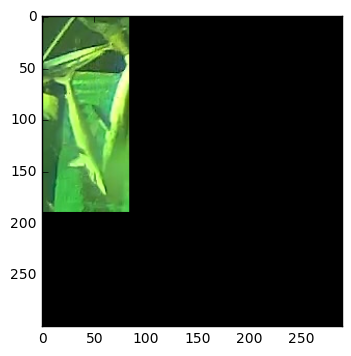

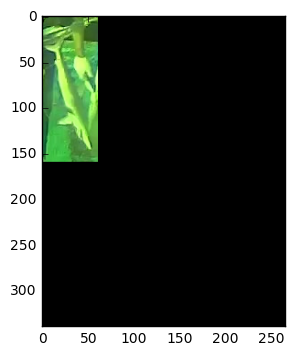

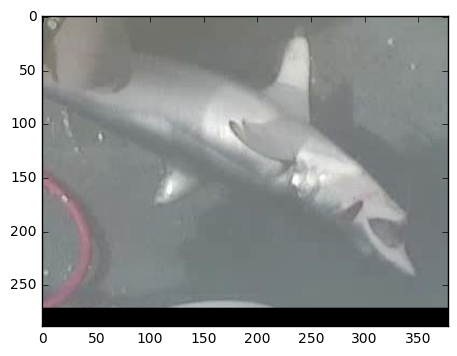

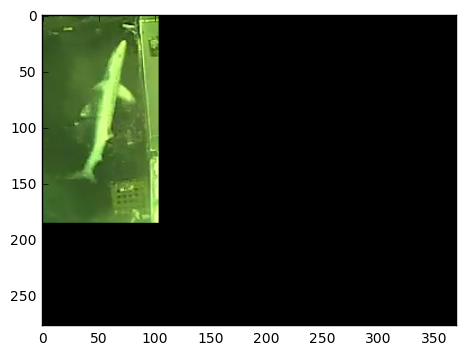

In [19]:
for i in range(len(x)):
    plt.imshow(array_to_img(x[i][2]))
    plt.show()

In [20]:
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics = ["accuracy"])

In [ ]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_4 (InputLayer)             (None, 3, None, None) 0                                            
____________________________________________________________________________________________________
input_5 (InputLayer)             (None, 3, None, None) 0                                            
____________________________________________________________________________________________________
input_6 (InputLayer)             (None, 3, None, None) 0                                            
____________________________________________________________________________________________________
input_7 (InputLayer)             (None, 3, None, None) 0                                            
___________________________________________________________________________________________

In [ ]:
model.fit_generator(itrain,validation_data=itest, nb_epoch=200, samples_per_epoch=64, callbacks=[remote], verbose=0, nb_val_samples=64)

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/yolo/AppData/Local/Theano/compiledir_Windows-10-10.0.14393-SP0-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-3.5.2-64/tmpfyn3oxrd/m9a6bd0eb5ed5c92e91261282fc495cb4.lib and object C:/Users/yolo/AppData/Local/Theano/compiledir_Windows-10-10.0.14393-SP0-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-3.5.2-64/tmpfyn3oxrd/m9a6bd0eb5ed5c92e91261282fc495cb4.exp

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/yolo/AppData/Local/Theano/compiledir_Windows-10-10.0.14393-SP0-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-3.5.2-64/tmpoofqhk9h/m848dd898e26d545ff6290e3aa98de3d5.lib and object C:/Users/yolo/AppData/Local/Theano/compiledir_Windows-10-10.0.14393-SP0-Intel64_Family_6_Model_60_Stepping_3_GenuineIntel-3.5.2-64/tmpoofqhk9h/m848dd898e26d545ff6290e3aa98de3d5.exp

DEBUG: nvcc STDOUT mod.cu
   Creating library C:/Users/yolo/AppData/Local/Theano/compiledir_Windows-10-10.0.14393-SP0-Intel64_Family_6_Model_60_Stepping_3_Genui

In [ ]:
for layers in model.layers[4].layers:
    layers.trainable = True

In [ ]:
path = "models/species_classifier.h5"

In [ ]:
model.save(path)

In [ ]:
model2 = load_model(path)

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("models/model55.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("models/model_weights55.h5")
print("Saved model into h5 file")

In [ ]:
from keras.models import model_from_json
json_file = open('models/model55.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("models/model_weights55.h5")
print("Loaded model from disk")